## Summarization with HuggingFace | NLP Projects | Fine Tuning T5 Transformer

## Coding

In [1]:
# !pip install -U transformers
# !pip install -U accelerate
# !pip install -U datasets
# !pip install -U bertviz
# !pip install -U umap-learn
# !pip install -U sentencepiece
# !pip install -U urllib3
# !pip install py7zr

In [1]:
# The CNN/DailyMail Dataset
# The CNN/DailyMail dataset consists of around 300,000 pairs of news articles and
# their corresponding summaries, composed from the bullet points that CNN and the
# DailyMail attach to their articles.
# summaries are abstractive and not extractive

import warnings
warnings.filterwarnings('ignore')

In [2]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", '3.0.0', split="train[:10]")

In [3]:
print(dataset[0]['article'])
print("\nSummary:\n")
print(dataset[0]['highlights'])

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details of how

In [4]:
from transformers import pipeline
import torch

device = 0 if torch.cuda.is_available() else -1
summary = {}

pipe = pipeline('summarization', model='ubikpt/t5-small-finetuned-cnn', device=device)
output = pipe(dataset[0]['article'])
summary['t5-small'] = output[0]['summary_text']

pipe = pipeline('summarization', model='facebook/bart-large-cnn', device=device)
output = pipe(dataset[0]['article'])
summary['bart-large'] = output[0]['summary_text']


Token indices sequence length is longer than the specified maximum sequence length for this model (638 > 512). Running this sequence through the model will result in indexing errors


In [5]:
for model in summary:
    print()
    print(model)
    print(summary[model])


t5-small
Harry Potter star Daniel Radcliffe says he has no plans to fritter his cash away . The actor has filmed a TV movie about author Rudyard Kipling

bart-large
Harry Potter star Daniel Radcliffe turns 18 on Monday. He gains access to a reported £20 million ($41.1 million) fortune. Radcliffe's earnings from the first five Potter films have been held in a trust fund. Details of how he'll mark his landmark birthday are under wraps.


### Fine-Tuning Summarization Model on Custom Dataset

In [7]:
samsum = load_dataset("knkarthick/samsum", trust_remote_code=True)

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'knkarthick/samsum' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
Generating test split: 100%|██████████| 819/819 [00:00<00:00, 81890.32 examples/s]


In [11]:
samsum['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\nJerry: Sure!\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [13]:
dialogue_len = [len(x['dialogue'].split()) for x in samsum['train'] if x['dialogue'] is not None]
summary_len = [len(x['summary'].split()) for x in samsum['train'] if x['summary'] is not None]


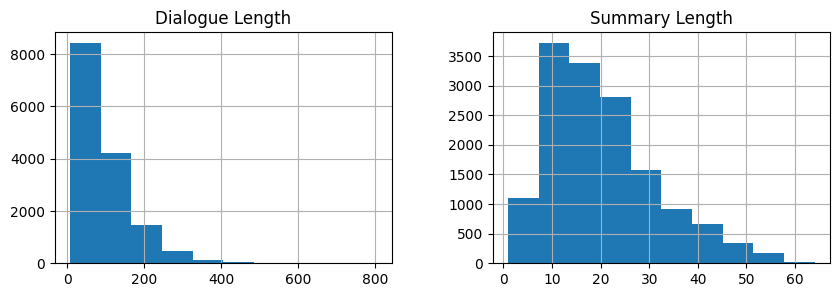

In [17]:
import pandas as pd
import matplotlib.pyplot as plt   # matplotlib'i import etmeyi unutma

data = pd.DataFrame([dialogue_len, summary_len]).T
data.columns = ['Dialogue Length', 'Summary Length']

data.hist(figsize=(10,3))
plt.show()


## Model Loading and Tokenization

In [18]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_ckpt = 't5-small'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [22]:
samsum['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\nJerry: Sure!\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [23]:
tokenizer(samsum['train'][0]['dialogue'], text_target=samsum['train'][0]['summary'], return_tensors='pt')

{'input_ids': tensor([[21542,    10,    27, 13635,  5081,     5,   531,    25,   241,   128,
            58, 16637,    10, 10625,    55, 21542,    10,    27,    31,   195,
           830,    25,  5721,     3,    10,    18,    61,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'labels': tensor([[21542, 13635,  5081,    11,    56,   830, 16637,   128,  5721,     5,
             1]])}

In [28]:
samsum = samsum.filter(lambda x: x["dialogue"] is not None and x["summary"] is not None)


Filter: 100%|██████████| 819/819 [00:00<00:00, 9486.13 examples/s]


In [29]:
def tokenize(batch):
    return tokenizer(
        list(batch["dialogue"]),
        text_target=list(batch["summary"]),
        max_length=200,
        truncation=True,
        padding="max_length"
    )


In [34]:
samsum_pt = samsum.map(tokenize, batched=True, batch_size=None)

Map: 100%|██████████| 819/819 [00:00<00:00, 6448.91 examples/s]


In [36]:
samsum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14731
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
})

## Model Training

In [37]:
from transformers import DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

args = TrainingArguments(
    output_dir="train_dir",
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_strategy='epoch',
    save_strategy='epoch',
    weight_decay=0.01,
    learning_rate=2e-5,
    gradient_accumulation_steps=500
)

trainer = Trainer(model=model,
                  args=args,
                  tokenizer=tokenizer,
                  data_collator=data_collator,
                  train_dataset=samsum_pt['train'],
                  eval_dataset=samsum_pt['validation']
                  )

trainer.train()

                                              
 50%|█████     | 7/14 [03:58<03:43, 31.87s/it]   

{'eval_loss': 15.736599922180176, 'eval_runtime': 4.377, 'eval_samples_per_second': 186.886, 'eval_steps_per_second': 46.836, 'epoch': 0.95}


                                               
100%|██████████| 14/14 [07:46<00:00, 31.94s/it]  

{'eval_loss': 14.763813972473145, 'eval_runtime': 4.5825, 'eval_samples_per_second': 178.504, 'eval_steps_per_second': 44.735, 'epoch': 1.9}


100%|██████████| 14/14 [07:47<00:00, 33.41s/it]

{'train_runtime': 467.7323, 'train_samples_per_second': 62.989, 'train_steps_per_second': 0.03, 'train_loss': 14.822032383510045, 'epoch': 1.9}


TrainOutput(global_step=14, training_loss=14.822032383510045, metrics={'train_runtime': 467.7323, 'train_samples_per_second': 62.989, 'train_steps_per_second': 0.03, 'total_flos': 1480248085708800.0, 'train_loss': 14.822032383510045, 'epoch': 1.9006244909041543})

In [38]:
trainer.save_model("t5_samsum_summarization")

## Prediction

In [39]:
from transformers import pipeline

In [40]:
pipe = pipeline('summarization', model='t5_samsum_summarization', device=device)

custom_dialogue="""
Laxmi Kant: what work you planning to give Tom?
Juli: i was hoping to send him on a business trip first.
Laxmi Kant: cool. is there any suitable work for him?
Juli: he did excellent in last quarter. i will assign new project, once he is back.
"""

output = pipe(custom_dialogue)
output

Your max_length is set to 200, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


[{'summary_text': 'laxmi: i was hoping to send him on a business trip first . i will assign new project once he is back .'}]

In [41]:
pipe = pipeline('summarization', model='t5_samsum_summarization', device=device)

custom_dialogue="""
Laxmi Kant: Tom’a ne tür bir iş vermeyi planlıyorsun?
Juli: Önce onu bir iş seyahatine göndermeyi düşünüyordum.
Laxmi Kant: Güzel. Onun için uygun bir iş var mı?
Juli: Geçen çeyrekte çok başarılıydı. Döndüğünde ona yeni bir proje atayacağım.
"""

output = pipe(custom_dialogue)
output


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


[{'summary_text': 'nce onu bir iş seyahatine göndermeyi düşünüyordum? Juli: Geçen çeyrekte çok başarlyd.'}]